## Organizar datos 


In [149]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#  Cargar los datos del archivo CSV
Fecha = '2023-02-01'
df_SFV = pd.read_csv('../../Data/Cleaned/SFV_2023.csv', sep=',')
df_solcast = pd.read_csv('../../Data/Cleaned/solcast_2023.csv', sep=',')
row_day_solcast = df_solcast.loc[df_solcast['Date'] == Fecha]
row_day_fronius = df_SFV.loc[df_SFV['Date'] == Fecha]
# reiniciar el index
row_day_solcast = row_day_solcast.reset_index(drop=True)
row_day_fronius = row_day_fronius.reset_index(drop=True)
# Odenernar row_day_solcast de menor a mayor hora
row_day_solcast = row_day_solcast.sort_values(by='Time')
row_day_solcast = row_day_solcast.reset_index(drop=True)
# Crear un nuevo dataframe con los datos de solcast y fronius a partir del indice 
df = pd.DataFrame()
df['Time'] = row_day_solcast['Time']
df['GHI'] = row_day_solcast['GHI']
df['air_temp'] = row_day_solcast['air_temp']
df['cloud_opacity'] = row_day_solcast['cloud_opacity']
df['Producción_fotovoltaica_SFV'] = row_day_fronius['Producción_fotovoltaica_SFV']
df['clearsky_ghi'] = row_day_solcast['clearsky_ghi']

## Normalizar los datos 

In [150]:
# normalizar los datos
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['GHI', 'Producción_fotovoltaica_SFV', 'clearsky_ghi', 'cloud_opacity', 'air_temp']] = scaler.fit_transform(df[['GHI', 'Producción_fotovoltaica_SFV', 'clearsky_ghi', 'cloud_opacity', 'air_temp']])
# print(df.head(2))

## Save to tensors


In [151]:
import torch

ghi_numpy = df['GHI'].to_numpy()
# Convertir el array de numpy a un tensor de PyTorch
ghi_tensor = torch.from_numpy(ghi_numpy)

air_temp_numpy = df['air_temp'].to_numpy()
# Convertir el array de numpy a un tensor de PyTorch
air_temp_tensor = torch.from_numpy(air_temp_numpy)

cloud_opacity_numpy = df['cloud_opacity'].to_numpy()
# Convertir el array de numpy a un tensor de PyTorch
cloud_opacity_tensor = torch.from_numpy(cloud_opacity_numpy)

produccion_numpy = df['Producción_fotovoltaica_SFV'].to_numpy()
# Convertir el array de numpy a un tensor de PyTorch
produccion_tensor = torch.from_numpy(produccion_numpy)



# Cambiar la forma a [288, 1] usando .view()
ghi_tensor = ghi_tensor.view(-1, 1)
air_temp_tensor = air_temp_tensor.view(-1, 1)
cloud_opacity_tensor = cloud_opacity_tensor.view(-1, 1)
produccion_tensor = produccion_tensor.view(-1, 1)

# shape ghi_tensor
print(produccion_tensor.shape)  # Salida: torch.Size([288, 1])

print("🌼")
# Concatenar los tensores a lo largo de la segunda dimensión para obtener un tensor de dimensiones (288, 3)
concatenado = torch.cat((ghi_tensor, air_temp_tensor, cloud_opacity_tensor), dim=1)
print(concatenado.shape)  # Salida: torch.Size([288, 3])
# # Cambiar la forma del tensor concatenado a (1, 288, 3)
# day = concatenado.unsqueeze(0)

# day2 = concatenado.unsqueeze(0)


# # concatenar day y day2 a lo largo de la primera dimensión
# days = torch.cat((day, day2), dim=0)

# # shape days
# print(days.shape)  # Salida: torch.Size([2, 288, 3])



torch.Size([288, 1])
🌼
torch.Size([288, 3])


## Aplanar el tensor concatenado

In [156]:
# Aplanar el tensor a [864, 1] usando .reshape()
aplanado = concatenado.reshape(-1, 1)

# Verificar las nuevas dimensiones
print(aplanado.shape)
# save tensor 
np.save('tensor_2024-02-01.npy', aplanado)

torch.Size([864, 1])


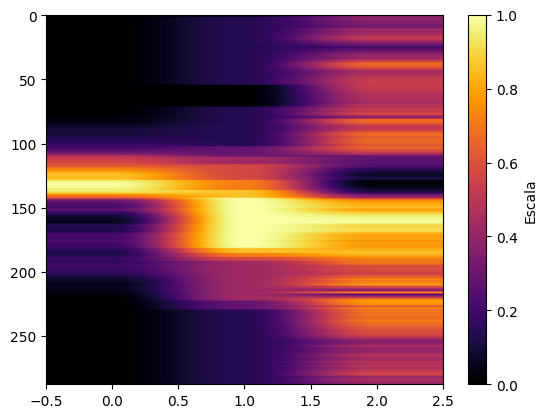

In [113]:
plt.imshow(days[1], aspect='auto', cmap='inferno')
plt.colorbar(label='Escala')


plt.show()

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Cargar los datos del archivo CSV
df_SFV = pd.read_csv('../../Data/Cleaned/SFV_2023.csv', sep=',')
df_solcast = pd.read_csv('../../Data/Cleaned/solcast_2023.csv', sep=',')

# Obtener fechas únicas
fechas_unicas = df_solcast['Date'].unique()

# Lista para guardar los tensores de cada día
tensors_dias = []

# Escalador MinMax
scaler = MinMaxScaler()

for fecha in fechas_unicas:
    row_day_solcast = df_solcast.loc[df_solcast['Date'] == fecha]
    row_day_fronius = df_SFV.loc[df_SFV['Date'] == fecha]

    # Resetear y ordenar por hora
    row_day_solcast = row_day_solcast.sort_values(by='Time').reset_index(drop=True)
    row_day_fronius = row_day_fronius.reset_index(drop=True)

    # Crear DataFrame para el día actual
    df_dia = pd.DataFrame({
        'Time': row_day_solcast['Time'],
        'GHI': row_day_solcast['GHI'],
        'air_temp': row_day_solcast['air_temp'],
        'cloud_opacity': row_day_solcast['cloud_opacity'],
        'Producción_fotovoltaica_SFV': row_day_fronius['Producción_fotovoltaica_SFV'],
        'clearsky_ghi': row_day_solcast['clearsky_ghi'],
    })

    # Normalizar los datos
    df_dia[['GHI', 'Producción_fotovoltaica_SFV', 'clearsky_ghi', 'cloud_opacity', 'air_temp']] = scaler.fit_transform(df_dia[['GHI', 'Producción_fotovoltaica_SFV', 'clearsky_ghi', 'cloud_opacity', 'air_temp']])

    # Convertir a tensor y cambiar forma
    ghi_tensor = torch.tensor(df_dia['GHI'].values).view(-1, 1)
    air_temp_tensor = torch.tensor(df_dia['air_temp'].values).view(-1, 1)
    cloud_opacity_tensor = torch.tensor(df_dia['cloud_opacity'].values).view(-1, 1)

    # Concatenar y cambiar forma a [1, 288, 3]
    dia_tensor = torch.cat((ghi_tensor, air_temp_tensor, cloud_opacity_tensor), dim=1).unsqueeze(0)
    # print(dia_tensor.shape)



## modelo de datos para todos los días

In [130]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Cargar los datos del archivo CSV
df_SFV = pd.read_csv('../../Data/Cleaned/SFV_2023.csv', sep=',')
df_solcast = pd.read_csv('../../Data/Cleaned/solcast_2023.csv', sep=',')

# Obtener fechas únicas
fechas_unicas = df_solcast['Date'].unique()

# Lista para guardar los tensores de cada día
tensors_dias = []

# Escalador MinMax
scaler = MinMaxScaler()

for fecha in fechas_unicas:
    row_day_solcast = df_solcast.loc[df_solcast['Date'] == fecha]
    row_day_fronius = df_SFV.loc[df_SFV['Date'] == fecha]

    # Verificar que el día tiene 288 registros
    if len(row_day_solcast) == 288 and len(row_day_fronius) == 288:
        # Procesamiento normal...
        # Resetear y ordenar por hora
        row_day_solcast = row_day_solcast.sort_values(by='Time').reset_index(drop=True)
        row_day_fronius = row_day_fronius.reset_index(drop=True)
    
        # Crear DataFrame para el día actual
        df_dia = pd.DataFrame({
            'Time': row_day_solcast['Time'],
            'GHI': row_day_solcast['GHI'],
            'air_temp': row_day_solcast['air_temp'],
            'cloud_opacity': row_day_solcast['cloud_opacity'],
            'Producción_fotovoltaica_SFV': row_day_fronius['Producción_fotovoltaica_SFV'],
            'clearsky_ghi': row_day_solcast['clearsky_ghi'],
        })
    
        # Normalizar los datos
        df_dia[['GHI', 'Producción_fotovoltaica_SFV', 'clearsky_ghi', 'cloud_opacity', 'air_temp']] = scaler.fit_transform(df_dia[['GHI', 'Producción_fotovoltaica_SFV', 'clearsky_ghi', 'cloud_opacity', 'air_temp']])
    
        # Convertir a tensor y cambiar forma
        ghi_tensor = torch.tensor(df_dia['GHI'].values).view(-1, 1)
        air_temp_tensor = torch.tensor(df_dia['air_temp'].values).view(-1, 1)
        cloud_opacity_tensor = torch.tensor(df_dia['cloud_opacity'].values).view(-1, 1)
    
        # Concatenar y cambiar forma a [1, 288, 3]
        dia_tensor = torch.cat((ghi_tensor, air_temp_tensor, cloud_opacity_tensor), dim=1).unsqueeze(0)
    
        # Agregar el tensor del día a la lista
        tensors_dias.append(dia_tensor)

# Verificar si hay días para concatenar
if tensors_dias:
    # Concatenar todos los tensores de días en un tensor [n, 288, 3]
    tensor_final = torch.cat(tensors_dias, dim=0)
    print(tensor_final.shape)  # Salida esperada: torch.Size([n, 288, 3])
    # Almacenar el tensor en un archivo
    np.save('tensor_entradas.npy', tensor_final)
else:
    print("No hay suficientes datos para crear el tensor final.")


torch.Size([180, 288, 3])


## Exportar tensor de validación solamente para DB

In [164]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Cargar los datos del archivo CSV
df_solcast = pd.read_csv('../../Data/Cleaned/solcast_2023.csv', sep=',')

# Obtener fechas únicas
fechas_unicas = df_solcast['Date'].unique()

# Lista para guardar los tensores de cada día
tensors_dias = []

# Escalador MinMax
scaler = MinMaxScaler()

for fecha in fechas_unicas:
    row_day_solcast = df_solcast.loc[df_solcast['Date'] == fecha]

    # Verificar que el día tiene 288 registros
    if len(row_day_solcast) == 288:
        # Resetear y ordenar por hora
        row_day_solcast = row_day_solcast.sort_values(by='Time').reset_index(drop=True)
    
        # Crear DataFrame para el día actual con las columnas deseadas
        df_dia = pd.DataFrame({
            'Time': row_day_solcast['Time'],
            'GHI': row_day_solcast['GHI'],
            'air_temp': row_day_solcast['air_temp'],
            'cloud_opacity': row_day_solcast['cloud_opacity'],
            'clearsky_ghi': row_day_solcast['clearsky_ghi'],
        })
    
        # Normalizar los datos
        df_dia[['GHI', 'clearsky_ghi', 'cloud_opacity', 'air_temp']] = scaler.fit_transform(df_dia[['GHI', 'clearsky_ghi', 'cloud_opacity', 'air_temp']])
    
        # Convertir a tensor y cambiar forma
        ghi_tensor = torch.tensor(df_dia['GHI'].values).view(-1, 1)
        air_temp_tensor = torch.tensor(df_dia['air_temp'].values).view(-1, 1)
        cloud_opacity_tensor = torch.tensor(df_dia['cloud_opacity'].values).view(-1, 1)
    
        # Concatenar y cambiar forma a [1, 288, 3]
        dia_tensor = torch.cat((ghi_tensor, air_temp_tensor, cloud_opacity_tensor), dim=1).unsqueeze(0)
    
        # Agregar el tensor del día a la lista
        tensors_dias.append(dia_tensor)

# Verificar si hay días para concatenar
if tensors_dias:
    # Concatenar todos los tensores de días en un tensor [n, 288, 3]
    tensor_final = torch.cat(tensors_dias, dim=0)
    print(tensor_final.shape)  # Salida esperada: torch.Size([n, 288, 3])
    # Almacenar el tensor en un archivo
    np.save('tensor_entradas.npy', tensor_final)
else:
    print("No hay suficientes datos para crear el tensor final.")


torch.Size([365, 288, 3])


## Aplanar los tensores para que cada día sea un vector único de entradas

In [166]:
tensor_validacion = tensor_final.reshape(tensor_final.shape[0], -1)
print(tensor_validacion.shape)  # Salida esperada: torch.Size([n, 864]) 
# Almacenar el tensor en un archivo
np.save('tensor_validacion.npy', tensor_validacion)

torch.Size([365, 864])


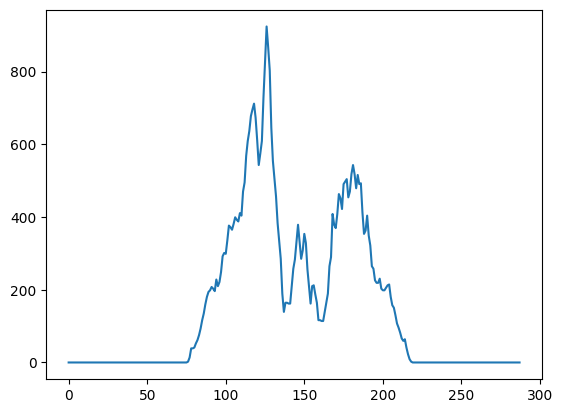

In [170]:
min_ghi = 0  # Mínimo valor de GHI antes de la normalización
max_ghi = 924  # Máximo valor de GHI antes de la normalización

# Simulación del proceso de reconstrucción de GHI para un día, necesitas iterar esto para cada día
ghi_normalizado = tensor_validacion[0].view(288, 3)[:, 0]  # Ejemplo para el primer día
ghi_reconstruido = ghi_normalizado * (max_ghi - min_ghi) + min_ghi

# Imprimir el tensor reconstruido de GHI para verificar
# print(ghi_reconstruido)

# graficar
import matplotlib.pyplot as plt

plt.plot(ghi_reconstruido)
plt.show()

## Tensor producción SFV

In [143]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Cargar los datos del archivo CSV
df_SFV = pd.read_csv('../../Data/Cleaned/SFV_2023.csv', sep=',')
df_solcast = pd.read_csv('../../Data/Cleaned/solcast_2023.csv', sep=',')

# Obtener fechas únicas
fechas_unicas = df_solcast['Date'].unique()

# Lista para guardar los tensores de cada día de la producción fotovoltaica
tensors_SFV = []

# Escalador MinMax
scaler = MinMaxScaler()

for fecha in fechas_unicas:
    row_day_solcast = df_solcast.loc[df_solcast['Date'] == fecha]
    row_day_fronius = df_SFV.loc[df_SFV['Date'] == fecha]

    # Verificar que el día tiene 288 registros
    if len(row_day_solcast) == 288 and len(row_day_fronius) == 288:
        # Resetear y ordenar por hora
        row_day_solcast = row_day_solcast.sort_values(by='Time').reset_index(drop=True)
        row_day_fronius = row_day_fronius.reset_index(drop=True)
    
        # Crear DataFrame para el día actual
        df_dia = pd.DataFrame({
            'Time': row_day_solcast['Time'],
            'GHI': row_day_solcast['GHI'],
            'air_temp': row_day_solcast['air_temp'],
            'cloud_opacity': row_day_solcast['cloud_opacity'],
            'Producción_fotovoltaica_SFV': row_day_fronius['Producción_fotovoltaica_SFV'],
            'clearsky_ghi': row_day_solcast['clearsky_ghi'],
        })
    
        # Normalizar los datos de interés
        df_dia['Producción_fotovoltaica_SFV'] = scaler.fit_transform(df_dia[['Producción_fotovoltaica_SFV']])
    
        # Convertir la producción a tensor y cambiar forma
        produccion_tensor = torch.tensor(df_dia['Producción_fotovoltaica_SFV'].values).view(1, -1, 1)
        
        # Agregar el tensor del día a la lista
        tensors_SFV.append(produccion_tensor)

# Concatenar todos los tensores de días en un tensor [n, 288, 1]
if tensors_SFV:
    tensor_final = torch.cat(tensors_SFV, dim=0)
    print(tensor_final.shape)  # Salida esperada: torch.Size([n, 288, 1])
    # Almacenar el tensor en un archivo
    np.save('tensor_SFV.npy', tensor_final)
else:
    print("No hay suficientes datos para crear el tensor final.")


torch.Size([180, 288, 1])


## Grafica DF

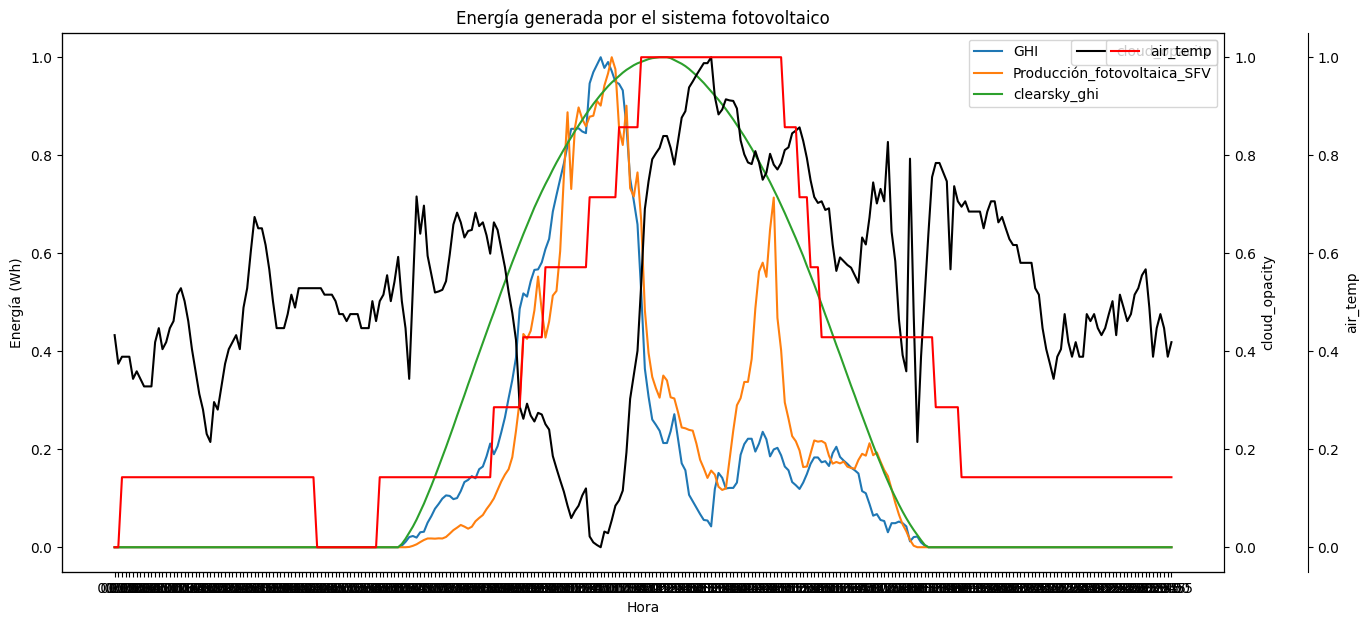

In [114]:
# print(df.head(2))
# graficar las variables

fig, ax = plt.subplots()
#size of the figure
fig.set_size_inches(15, 7)

ax.plot(df['Time'], df['GHI'], label='GHI')
ax.plot(df['Time'], df['Producción_fotovoltaica_SFV'], label='Producción_fotovoltaica_SFV')
ax.plot(df['Time'], df['clearsky_ghi'], label='clearsky_ghi')
#add cloud_opacity
ax2 = ax.twinx()
ax2.plot(df['Time'], df['cloud_opacity'], label='cloud_opacity', color='black')
ax2.set_ylabel('cloud_opacity')
#add air_temp
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(df['Time'], df['air_temp'], label='air_temp', color='red')
ax3.set_ylabel('air_temp')


ax.set(xlabel='Hora', ylabel='Energía (Wh)',
       title='Energía generada por el sistema fotovoltaico')
ax.legend()
ax2.legend()
ax3.legend()
plt.show()

## Normalización de los datos

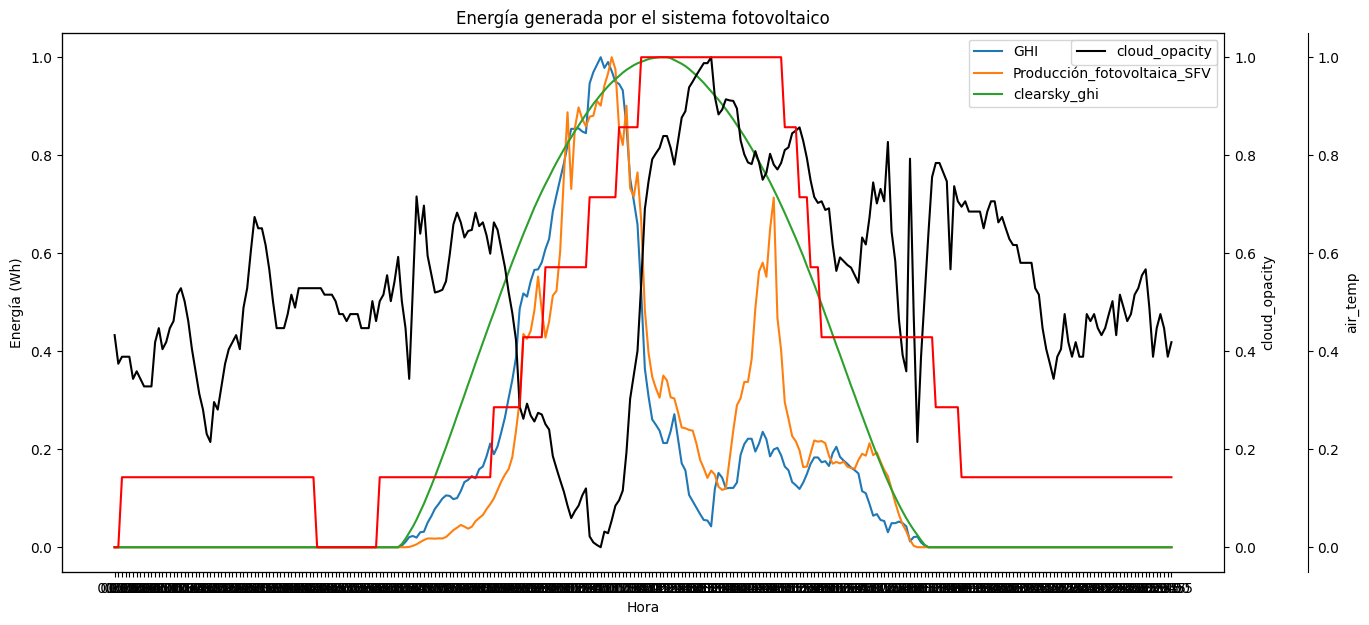

In [115]:
# normalizar los datos
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['GHI', 'Producción_fotovoltaica_SFV', 'clearsky_ghi', 'cloud_opacity', 'air_temp']] = scaler.fit_transform(df[['GHI', 'Producción_fotovoltaica_SFV', 'clearsky_ghi', 'cloud_opacity', 'air_temp']])
# print(df.head(2))
# graficar las variables normalizadas
fig, ax = plt.subplots()
#size of the figure
fig.set_size_inches(15, 7)

ax.plot(df['Time'], df['GHI'], label='GHI')
ax.plot(df['Time'], df['Producción_fotovoltaica_SFV'], label='Producción_fotovoltaica_SFV')
ax.plot(df['Time'], df['clearsky_ghi'], label='clearsky_ghi')
#add cloud_opacity
ax2 = ax.twinx()
ax2.plot(df['Time'], df['cloud_opacity'], label='cloud_opacity', color='black')
ax2.set_ylabel('cloud_opacity')
#add air_temp
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(df['Time'], df['air_temp'], label='air_temp', color='red')
ax3.set_ylabel('air_temp')
ax.set(xlabel='Hora', ylabel='Energía (Wh)',
         title='Energía generada por el sistema fotovoltaico')
ax.legend()
ax2.legend()
plt.show()





## Ejemplo CNN

In [116]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Cargar el conjunto de datos MNIST
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

In [117]:
# Normalizar los datos de las imágenes
train_images, test_images = train_images / 255.0, test_images / 255.0


# Ajustar el tamaño de los datos para incluir el canal de color
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))


In [118]:
print(train_images.shape)
print(test_labels.shape)
print(train_images[1].shape)
print(test_labels[1])
print(test_labels)
#type test_labels pint
print(type(test_labels))
#shape
print(test_labels.shape)

# Almacenar el tensor en un archivo
np.save('mi_tensor.npy', test_labels)


(60000, 28, 28, 1)
(10000,)
(28, 28, 1)
2
[7 2 1 ... 4 5 6]
<class 'numpy.ndarray'>
(10000,)


In [119]:
# Cargar el tensor desde el archivo
tensor_cargado = np.load('mi_tensor.npy')
print(tensor_cargado)

[7 2 1 ... 4 5 6]


In [120]:
import numpy as np
train_images_example = np.random.rand(28, 28, 1)

# Imprimiendo las dimensiones para confirmar que coincide con (28, 28, 1)
print(train_images_example.shape)

(28, 28, 1)
